In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
import typing as tp

import arch
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyarrow
import scipy as sp
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from ovm.historical.data_io import (
    PriceHistoryColumnNames as PHCN, 
    compute_number_of_days_in_price_history, 
    compute_log_returns_from_price_history, 
    save_price_histories, 
    load_price_history
)

from ovm.paths import (
    HistoricalDataSource, 
    construct_historical_data_directory
)

from ovm.time_resolution import TimeResolution

In [3]:
from recombinator import (
    stationary_bootstrap, 
    tapered_block_bootstrap
)

from recombinator.optimal_block_length import optimal_block_length

In [4]:
%matplotlib inline

In [5]:
# def adf_test(timeseries):
#     print ('Results of Dickey-Fuller Test:')
#     dftest = adfuller(timeseries, autolag='AIC')
#     dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
#     for key,value in dftest[4].items():
#        dfoutput['Critical Value (%s)'%key] = value
#     print (dfoutput)

In [6]:
time_resolution = TimeResolution.FIFTEEN_SECONDS
directory_path = \
    construct_historical_data_directory(
        historical_data_source=HistoricalDataSource.FTX, 
        time_resolution=time_resolution)
directory_path

In [8]:
price_history_file_name = 'ETH-USD'

In [9]:
price_history = \
    load_price_history(filename=price_history_file_name, 
                       series_name=price_history_file_name, 
                       directory_path=directory_path, 
                       period_length_in_seconds=time_resolution.in_seconds)
df = price_history.price_history_df

In [10]:
# df = pd.read_parquet(path=os.path.join(directory_path, price_history_file_name))

In [11]:
df.tail(15)

,open,high,low,close,volume
start_time,,,,,
1606257540000,601.14,601.14,601.14,601.14,0.00000
1606257555000,601.14,601.23,601.11,601.23,0.00000
1606257570000,601.23,601.32,601.23,601.32,0.00000
1606257585000,601.32,601.32,601.32,601.32,0.00000
1606257600000,601.32,601.87,601.32,601.80,0.00000
1606257615000,601.80,602.47,601.80,602.47,1.80624
1606257630000,602.47,602.67,602.47,602.67,0.60248
1606257645000,602.67,602.90,602.67,602.90,1.20556
1606257660000,602.91,603.24,602.91,603.24,121.18508


In [12]:
# def compute_log_returns_from_price_history(price_history_df: pd.DataFrame, 
#                                            period_length_in_seconds: float, 
#                                            name: tp.Optional[str] = None) -> pd.Series:
#     log_returns = np.log(price_history_df[PHCN.CLOSE]).diff().dropna() * np.sqrt(365 * 24 * 60 * 60 / period_length_in_seconds)
#     if name is not None:
#         log_returns.name = name
#     return log_returns

In [13]:
log_return_series = \
    compute_log_returns_from_price_history(df, period_length_in_seconds=15, name='eth/usd return')

In [14]:
# log_return_series = np.log(df[PHCN.CLOSE]).diff().dropna() * np.sqrt(365 * 24 * 60 * 4)

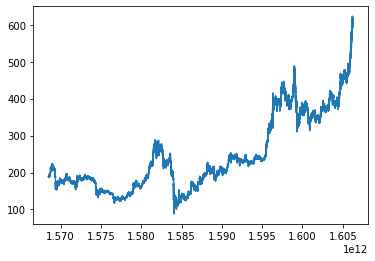

In [15]:
plt.plot(df[PHCN.CLOSE]);

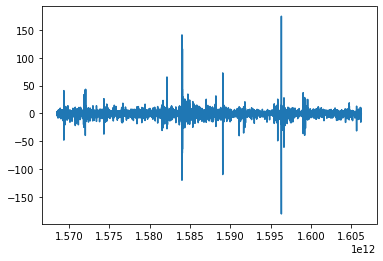

In [16]:
plt.plot(log_return_series);

## GJR Garch with Normal Distribution

In [17]:
# a standard GJR-GARCH(1,1) model
gjr_garch = arch.arch_model(log_return_series, 
                        vol='garch', 
                        p=1, 
                        o=1, 
                        q=1)
gjr_garch_fitted = gjr_garch.fit()
gjr_garch_fitted.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 298871595353.7077
Iteration:      2,   Func. Count:     22,   Neg. LLF: 2148565.6778441425
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2148565.6745523433
            Iterations: 6
            Function evaluations: 22
            Gradient evaluations: 2


<class 'statsmodels.iolib.summary.Summary'>
"""
                   Constant Mean - GJR-GARCH Model Results                    
==============================================================================
Dep. Variable:         eth/usd return   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:           -2.14857e+06
Distribution:                  Normal   AIC:                       4.29714e+06
Method:            Maximum Likelihood   BIC:                       4.29721e+06
                                        No. Observations:              2515223
Date:                Fri, Jan 22 2021   Df Residuals:                  2515218
Time:                        13:35:34   Df Model:                            5
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -8.0130e-03  4.458e-03     -1.798  7.225e-02 [-1.675e-02,7.240e-04]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0173  1.099e-02      1.577      0.115 [-4.211e-03,3.889e-02]
alpha[1]       0.1000  2.186e-02      4.575  4.755e-06    [5.716e-02,  0.143]
gamma[1]       0.1000  5.756e-02      1.737  8.232e-02   [-1.281e-02,  0.213]
beta[1]        0.8300  6.006e-02     13.819  1.970e-43      [  0.712,  0.948]
=============================================================================

Covariance estimator: robust
"""

## With Normal Distribution

In [18]:
# a standard GARCH(1,1) model
garch = arch.arch_model(log_return_series, 
                        vol='garch', 
                        p=1, 
                        o=0, 
                        q=1)
garch_fitted = garch.fit()
garch_fitted.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 15198100694.193094
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2155588.805328296
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2155588.816852394
            Iterations: 6
            Function evaluations: 19
            Gradient evaluations: 2


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:         eth/usd return   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:           -2.15559e+06
Distribution:                  Normal   AIC:                       4.31119e+06
Method:            Maximum Likelihood   BIC:                       4.31124e+06
                                        No. Observations:              2515223
Date:                Fri, Jan 22 2021   Df Residuals:                  2515219
Time:                        13:35:42   Df Model:                            4
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         3.9583e-03  3.918e-04     10.103  5.363e-24 [3.190e-03,4.726e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0173  5.604e-03      3.094  1.976e-03 [6.354e-03,2.832e-02]
alpha[1]       0.2000  3.185e-02      6.279  3.414e-10     [  0.138,  0.262]
beta[1]        0.7800  4.045e-02     19.282  7.555e-83     [  0.701,  0.859]
============================================================================

Covariance estimator: robust
"""

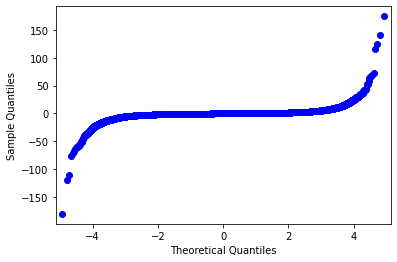

In [19]:
# plot residuals
sm.qqplot(garch_fitted.resid);

In [20]:
# a standard GARCH(1,2) model
garch_12 = arch.arch_model(log_return_series, 
                        vol='garch', 
                        p=1, 
                        o=0, 
                        q=2)
garch_12_fitted = garch_12.fit()
garch_12_fitted.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 146233422278516.78
Iteration:      2,   Func. Count:     21,   Neg. LLF: 17979184.584930327
Iteration:      3,   Func. Count:     31,   Neg. LLF: 85069436873637.98
Iteration:      4,   Func. Count:     44,   Neg. LLF: 2127846.8339645253
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2127846.835878087
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:         eth/usd return   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:           -2.12785e+06
Distribution:                  Normal   AIC:                       4.25570e+06
Method:            Maximum Likelihood   BIC:                       4.25577e+06
                                        No. Observations:              2515223
Date:                Fri, Jan 22 2021   Df Residuals:                  2515218
Time:                        13:35:54   Df Model:                            5
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         3.2719e-03  3.518e-04      9.299  1.414e-20 [2.582e-03,3.961e-03]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0173  9.108e-03      1.903  5.701e-02 [-5.165e-04,3.519e-02]
alpha[1]       0.2002  4.481e-02      4.467  7.939e-06      [  0.112,  0.288]
beta[1]        0.3901  8.372e-02      4.660  3.164e-06      [  0.226,  0.554]
beta[2]        0.3901  2.858e-02     13.653  1.943e-42      [  0.334,  0.446]
=============================================================================

Covariance estimator: robust
"""

In [21]:
# a standard GARCH(1,3) model
garch_13 = arch.arch_model(log_return_series, 
                        vol='garch', 
                        p=1, 
                        o=0, 
                        q=3)
garch_13_fitted = garch_13.fit()
garch_13_fitted.summary()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 6781580275.658885
Iteration:      2,   Func. Count:     23,   Neg. LLF: 3.5653417738783994e+17
Iteration:      3,   Func. Count:     36,   Neg. LLF: 2.2158628228867453e+19
Iteration:      4,   Func. Count:     50,   Neg. LLF: 1.196736936453928e+18
Iteration:      5,   Func. Count:     64,   Neg. LLF: 623348779168287.1
Iteration:      6,   Func. Count:     75,   Neg. LLF: 210001806.95024866
Iteration:      7,   Func. Count:     88,   Neg. LLF: 2119950.696974484
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2119950.694755092
            Iterations: 11
            Function evaluations: 88
            Gradient evaluations: 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:         eth/usd return   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:           -2.11995e+06
Distribution:                  Normal   AIC:                       4.23991e+06
Method:            Maximum Likelihood   BIC:                       4.23999e+06
                                        No. Observations:              2515223
Date:                Fri, Jan 22 2021   Df Residuals:                  2515217
Time:                        13:36:06   Df Model:                            6
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         2.8692e-03  3.381e-04      8.486  2.145e-17 [2.206e-03,3.532e-03]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0173  1.722e-02      1.007      0.314 [-1.642e-02,5.108e-02]
alpha[1]       0.2000  8.645e-02      2.313  2.073e-02    [3.051e-02,  0.369]
beta[1]        0.2599  8.357e-02      3.111  1.867e-03    [9.615e-02,  0.424]
beta[2]        0.2599  7.619e-02      3.412  6.458e-04      [  0.111,  0.409]
beta[3]        0.2599  4.401e-02      5.906  3.501e-09      [  0.174,  0.346]
=============================================================================

Covariance estimator: robust
"""

In [22]:
# a standard GARCH(2,1) model
garch_21 = arch.arch_model(log_return_series, 
                        vol='garch', 
                        p=2, 
                        o=0, 
                        q=1)
garch_21_fitted = garch_21.fit()
garch_21_fitted.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 17074344582.91698
Iteration:      2,   Func. Count:     22,   Neg. LLF: 17953382.309306044
Iteration:      3,   Func. Count:     33,   Neg. LLF: 9.789860030775487e+21
Iteration:      4,   Func. Count:     46,   Neg. LLF: 2164180.998818061
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2164181.0082995836
            Iterations: 8
            Function evaluations: 46
            Gradient evaluations: 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:         eth/usd return   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:           -2.16418e+06
Distribution:                  Normal   AIC:                       4.32837e+06
Method:            Maximum Likelihood   BIC:                       4.32844e+06
                                        No. Observations:              2515223
Date:                Fri, Jan 22 2021   Df Residuals:                  2515218
Time:                        13:36:18   Df Model:                            5
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         4.1823e-03  4.746e-04      8.812  1.232e-18 [3.252e-03,5.113e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0175  7.571e-03      2.316  2.054e-02 [2.698e-03,3.237e-02]
alpha[1]       0.1000  5.326e-03     18.779  1.128e-78   [8.958e-02,  0.110]
alpha[2]       0.1000  4.320e-02      2.315  2.059e-02   [1.535e-02,  0.185]
beta[1]        0.7800  5.742e-02     13.584  4.967e-42     [  0.667,  0.893]
============================================================================

Covariance estimator: robust
"""

## With T Distribution

In [23]:
# a GARCH(1,1) model with Student t distributed errors 
garch_11_t = \
    arch.arch_model(log_return_series, 
                    vol='garch', 
                    p=1, 
                    o=0, 
                    q=1, 
                    dist='StudentsT'
                   )
garch_11_t_fitted = garch_11_t.fit()
garch_11_t_fitted.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 214398673.52729997
Iteration:      2,   Func. Count:     20,   Neg. LLF: 1771834.7322120625
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1771834.7315221645
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:               eth/usd return   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:           -1.77183e+06
Distribution:      Standardized Student's t   AIC:                       3.54368e+06
Method:                  Maximum Likelihood   BIC:                       3.54374e+06
                                              No. Observations:              2515223
Date:                      Fri, Jan 22 2021   Df Residuals:                  2515218
Time:                              13:36:27   Df Model:                            5
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         7.1350e-05  1.560e-04      0.457      0.647 [-2.344e-04,3.771e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0173  1.096e-04    158.204      0.000 [1.712e-02,1.755e-02]
alpha[1]       0.2000  9.204e-04    217.299      0.000     [  0.198,  0.202]
beta[1]        0.7800  8.549e-04    912.373      0.000     [  0.778,  0.782]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             4.0220  7.024e-03    572.605      0.000 [  4.008,  4.036]
========================================================================

Covariance estimator: robust
"""

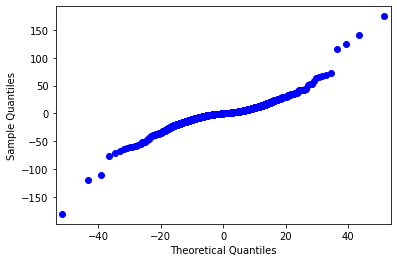

In [24]:
# plot residuals
sm.qqplot(garch_11_t_fitted.resid, dist=sp.stats.t(garch_11_t_fitted.params['nu']));

In [25]:
sim_mod = arch.arch_model(None, vol='garch', p=1, o=0, q=1, dist="StudentsT")

sim_data = sim_mod.simulate(garch_11_t_fitted.params, 1000)
sim_data.head()

,data,volatility,errors
0,-0.109799,0.500629,-0.109870
1,-0.596806,0.463943,-0.596877
2,-0.296657,0.506438,-0.296729
3,0.484932,0.484769,0.484861
4,-0.483777,0.497650,-0.483848


In [26]:
# a GARCH(1,2) model with Student t distributed errors 
garch_12_t = \
    arch.arch_model(log_return_series, 
                    vol='garch', 
                    p=1, 
                    o=0, 
                    q=2, 
                    dist='StudentsT')
garch_12_t_fitted = garch_12_t.fit()
garch_12_t_fitted.summary()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 764723437.7723403
Iteration:      2,   Func. Count:     22,   Neg. LLF: 1772364.3434145811
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1772364.3427048707
            Iterations: 6
            Function evaluations: 22
            Gradient evaluations: 2


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:               eth/usd return   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:           -1.77236e+06
Distribution:      Standardized Student's t   AIC:                       3.54474e+06
Method:                  Maximum Likelihood   BIC:                       3.54482e+06
                                              No. Observations:              2515223
Date:                      Fri, Jan 22 2021   Df Residuals:                  2515217
Time:                              13:36:44   Df Model:                            6
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         2.0644e-04  1.558e-04      1.325      0.185 [-9.893e-05,5.118e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0173  1.009e-04    171.888      0.000 [1.714e-02,1.753e-02]
alpha[1]       0.2000  9.414e-04    212.460      0.000     [  0.198,  0.202]
beta[1]        0.3900  5.175e-03     75.363      0.000     [  0.380,  0.400]
beta[2]        0.3900  5.222e-03     74.680      0.000     [  0.380,  0.400]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             4.0231  6.240e-03    644.777      0.000 [  4.011,  4.035]
========================================================================

Covariance estimator: robust
"""

In [27]:
# a GARCH(1,3) model with Student t distributed errors 
garch_13_t = arch.arch_model(log_return_series, 
                        vol='garch', 
                        p=1, 
                        o=0, 
                        q=3, 
                        dist='StudentsT')
garch_13_t_fitted = garch_13_t.fit()
garch_13_t_fitted.summary()

Iteration:      1,   Func. Count:      9,   Neg. LLF: 320579384.109592
Iteration:      2,   Func. Count:     24,   Neg. LLF: 1775522.7536625278
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1775522.7529379404
            Iterations: 6
            Function evaluations: 24
            Gradient evaluations: 2


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:               eth/usd return   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:           -1.77552e+06
Distribution:      Standardized Student's t   AIC:                       3.55106e+06
Method:                  Maximum Likelihood   BIC:                       3.55115e+06
                                              No. Observations:              2515223
Date:                      Fri, Jan 22 2021   Df Residuals:                  2515216
Time:                              13:36:58   Df Model:                            7
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -2.5935e-04  1.559e-04     -1.664  9.611e-02 [-5.648e-04,4.613e-05]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0173  9.854e-05    175.939      0.000 [1.714e-02,1.753e-02]
alpha[1]       0.2000  1.012e-03    197.622      0.000     [  0.198,  0.202]
beta[1]        0.2600  6.368e-03     40.827      0.000     [  0.248,  0.272]
beta[2]        0.2600  7.397e-03     35.150 1.154e-270     [  0.246,  0.274]
beta[3]        0.2600  6.666e-03     39.006      0.000     [  0.247,  0.273]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             4.0220  5.918e-03    679.591      0.000 [  4.010,  4.034]
========================================================================

Covariance estimator: robust
"""

## With Skewed T Distribution

In [28]:
# a GARCH(1,1) model with Student t distributed errors 
garch_11_skewt = \
    arch.arch_model(log_return_series, 
                    vol='garch', 
                    p=1, 
                    o=0, 
                    q=1, 
                    dist='skewt'
                   )
garch_11_skewt_fitted = garch_11_skewt.fit()
garch_11_skewt_fitted.summary()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 119880692.99891086
Iteration:      2,   Func. Count:     23,   Neg. LLF: 1771832.4399991932
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1771832.440179665
            Iterations: 6
            Function evaluations: 23
            Gradient evaluations: 2


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Constant Mean - GARCH Model Results                           
=========================================================================================
Dep. Variable:                    eth/usd return   R-squared:                      -0.000
Mean Model:                        Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                                 GARCH   Log-Likelihood:           -1.77183e+06
Distribution:      Standardized Skew Student's t   AIC:                       3.54368e+06
Method:                       Maximum Likelihood   BIC:                       3.54375e+06
                                                   No. Observations:              2515223
Date:                           Fri, Jan 22 2021   Df Residuals:                  2515217
Time:                                   13:37:14   Df Model:                            6
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         5.2161e-05  2.709e-04      0.193      0.847 [-4.789e-04,5.832e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0173  1.096e-04    158.200      0.000 [1.712e-02,1.755e-02]
alpha[1]       0.2000  9.204e-04    217.298      0.000     [  0.198,  0.202]
beta[1]        0.7800  8.549e-04    912.355      0.000     [  0.778,  0.782]
                                 Distribution                                
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
nu             4.0220  7.024e-03    572.597      0.000      [  4.008,  4.036]
lambda     4.4737e-08  6.075e-04  7.364e-05      1.000 [-1.191e-03,1.191e-03]
=============================================================================

Covariance estimator: robust
"""

In [29]:
bootstrap_log_returns = \
    stationary_bootstrap(x=log_return_series.values, 
                         block_length=24 * 60 * 60 / 15, 
                         replications=10)

In [30]:
bootstrap_log_returns.shape

(10, 2515223)

In [31]:
np.unique(np.diff(df.index.values))

array([  15000,   30000,   45000,   60000,   75000,   90000,  105000,
        120000,  135000,  150000,  165000,  180000,  195000,  210000,
        240000,  285000,  315000,  330000,  375000,  390000,  420000,
        540000,  555000,  630000,  765000,  795000,  870000, 1050000,
       1230000, 1245000, 4335000])

In [32]:
(np.diff(df.index.values) != 15000).sum()

759

(array([2.515212e+06, 6.000000e+00, 4.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([  15000.,  447000.,  879000., 1311000., 1743000., 2175000.,
        2607000., 3039000., 3471000., 3903000., 4335000.]),
 <BarContainer object of 10 artists>)

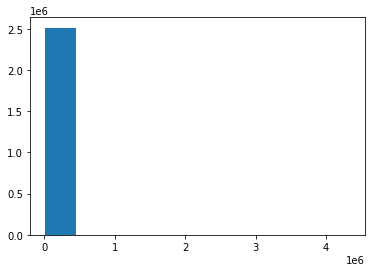

In [33]:
plt.hist(np.diff(df.index.values))

In [34]:
len(df)

2515224